In [140]:
%load_ext autoreload
%autoreload 2
import os
import sys
base_dir = '/Users/simon/git/ms1fun/'
sys.path.append(base_dir + 'code')
sys.path.append(base_dir + 'dbs')
from corr_cluster import Peak,BetaLike,CorrCluster
from formula import Formula
import pylab as plt
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Grab some std1 files

In [141]:
prefix = '/Users/simon/Dropbox/BioResearch/Meta_clustering/StandardData140606/csv/'
files = [f.split('.')[0] for f in os.listdir(prefix) if f.endswith('.csv') and 'Std_1' in f]
print files

['batch1_Std_1_1', 'batch1_Std_1_2', 'batch2_Std_1_1', 'batch2_Std_1_2', 'batch3_Std_1_1', 'batch3_Std_1_2', 'batch4_Std_1_1', 'batch4_Std_1_2']


In [142]:
filename = files[0]
bl = BetaLike()
print "Running file " + filename
csvfile = prefix + filename + '.csv'
matfile = prefix + filename + '.corr.mat'
signalfile = prefix + filename + '.peakml.signal'
coc = CorrCluster(bl,csvfile,matfile,signal_file=signalfile,greedy_thresh=0.9,correct=True)

Running file batch1_Std_1_1
1357.622802
Loaded 6150 peaks
Reading shape correlations from /Users/simon/Dropbox/BioResearch/Meta_clustering/StandardData140606/csv/batch1_Std_1_1.corr.mat
Greedy clustering done, resulting in 3186 clusters


In [346]:
import transformation
transformations = transformation.load_from_file(base_dir + 'dbs/pos_transformations_reduced.yml')
print "Loaded " + str(len(transformations)) + " transformations"

Loaded 54 transformations


Transform a cluster and see what we get

In [348]:
def print_cluster(cluster):
    plt.figure()
    for peak in cluster.members:
        plt.plot([peak.mass,peak.mass],[0,peak.intensity],'r')

In [349]:
import numpy as np
from scipy import stats

Bin the masses into nominal (integer bins)

In [ ]:
PROTON = 1.00727645199076


class Mol(object):
    def __init__(self,name,formula,mass,rt):
        self.name = name.strip()
        self.formula = formula.strip()
        self.mass = mass
        self.rt = rt
    def __str__(self):
        return self.name
    def __repr__(self):
        return self.name

Ignore the following 2 cells

In [47]:
mols = []
combined_file = base_dir + 'dbs/StandardsCombined_20150422_forJoe.csv'



print combined_file
with open(combined_file,'rU') as f:
    heads = f.readline()
    for line in f:
        split_line = line.split(',')
        if int(split_line[0])==1:
            f = Formula(split_line[2])
            new_mol = Mol(split_line[1],split_line[2],f.compute_exact_mass(),float(split_line[5]))
            mols.append(new_mol)


mols = sorted(mols,key=lambda x: x.mass)
print len(mols)

/Users/simon/git/ms1fun/dbs/StandardsCombined_20150422_forJoe.csv
82


In [52]:
std_file = base_dir + 'dbs/std1_mols.csv'
mols = []
with open(std_file,'rU') as f:
    for line in f:
        split_line = line.split(',')
        f = Formula(split_line[2].strip())
        new_mol = Mol(split_line[1],split_line[2].strip(),f.compute_exact_mass(),0.0)
        mols.append(new_mol)
mols = sorted(mols,key=lambda x:x.mass)
print len(mols)

104


This is the one to use (for now)

In [350]:
std_file = base_dir + 'dbs/std1_20130822_130526.csv'
mols = []
with open(std_file,'rU') as f:
    for i in range(9):
        f.readline() # remove heads
    for line in f:
        split_line = line.split(',')
        polarity = split_line[4]
        rt = float(split_line[8])
        if polarity == '+' and rt > 0.0:
            name = split_line[2]
            formula = split_line[3]
            rt = float(split_line[8])
            f = Formula(formula)
            new_mol = Mol(name,formula,f.compute_exact_mass(),rt*60.0)
            mols.append(new_mol)
mols = sorted(mols,key = lambda x: x.mass)

Find some matches to play with some more

In [415]:
protonated = [t for t in transformations if t.name=='M+H'][0]

In [416]:
def hit(m1,m2,rt1,rt2,mtol=5,rttol=1):
    if 1e6*np.abs(m1-m2)/m2 < mtol and np.abs(rt1-rt2)<rttol:
        return True
    else:
        return False
    
def get_hits(peaks,mols,transformations,mtol=10,rttol = 120.0):
    hits = {}
    for mol in mols:
        for peak in peaks:
            for t in transformations:
                if hit(t.transform(peak),mol.mass,peak.rt,mol.rt,mtol = mtol,rttol = rttol):
                    if mol in hits:
                        if np.abs(peak.rt - mol.rt) < np.abs(hits[mol].rt - mol.rt):
                            hits[mol] = peak
                    else:
                        hits[mol] = peak
    return hits

{Cytidine: <corr_cluster.Peak object at 0x10c680f10>, L-Glutamine: <corr_cluster.Peak object at 0x10ed9b450>, Phenylhydrazine: <corr_cluster.Peak object at 0x10c417d50>, Adenine: <corr_cluster.Peak object at 0x10c5270d0>, 4-Aminobenzoate: <corr_cluster.Peak object at 0x10c6802d0>, L-Leucine: <corr_cluster.Peak object at 0x10ae31810>, Selenomethionine: <corr_cluster.Peak object at 0x10c509b50>, L-Tryptophan: <corr_cluster.Peak object at 0x10ae351d0>, Nicotinate: <corr_cluster.Peak object at 0x10ca62310>, Creatinine: <corr_cluster.Peak object at 0x10c509790>, D-Glucosamine: <corr_cluster.Peak object at 0x10ed9bd10>, L-Phenylalanine: <corr_cluster.Peak object at 0x10cac8950>, L-Threonine: <corr_cluster.Peak object at 0x10cacf550>, sn-glycero-3-Phosphocholine: <corr_cluster.Peak object at 0x10eda52d0>, riboflavin: <corr_cluster.Peak object at 0x10d5c5fd0>, L-Proline: <corr_cluster.Peak object at 0x10c509ad0>, Inosine: <corr_cluster.Peak object at 0x110588810>, Glycerol: <corr_cluster.Peak 

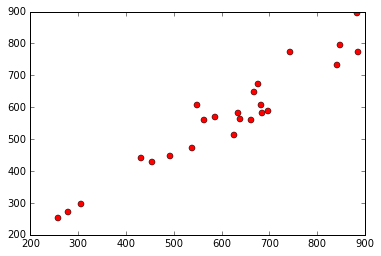

In [417]:
hits = get_hits(coc.peaks,mols,[protonated])
true = []
measured = []
for mol in hits:
    true.append(mol.rt)
    measured.append(hits[mol].rt)
plt.plot(true,measured,'ro')
print hits

Look at an individual cluster and see what we can find

Cluster has 15 members
117.078978603 118.086176646 159613568.0


(107.07897860297999, 127.07897860297999)

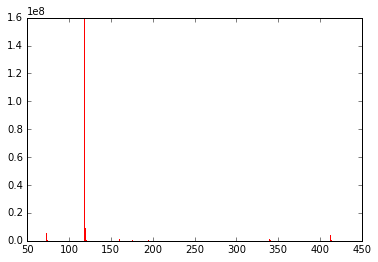

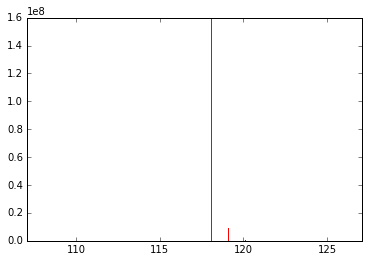

In [406]:
mi = [m for m in mols if m.name=='Selenomethionine'][0]
mip = hits[mi]
cluster = coc.Z[mip]
print "Cluster has {} members".format(len(cluster.members))
plot_peaks(cluster.members,log=False)
plot_peaks(cluster.members,log=False)
print mi.mass,mip.mass,mip.intensity
plt.xlim([mi.mass-10,mi.mass+10])

In [407]:
def plot_peaks(peaks,log=False):
    plt.figure()
    for p in peaks:
        if log:
            plt.semilogy([p.mass,p.mass],[0,p.intensity],'r')
        else:
            plt.plot([p.mass,p.mass],[0,p.intensity],'r')

810


(117.06897860297998, 117.08897860297999)

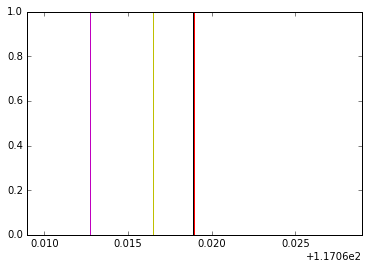

In [408]:
transformed_masses = []
actual_transforms = []
for peak in cluster.members:
    for tr in transformations:
        transformed_masses.append(tr.transform(peak))
        actual_transforms.append(tr)
temp = zip(transformed_masses,actual_transforms)
temp = sorted(temp,key = lambda x: x[0])
transformed_masses,actual_transforms = zip(*temp)
transformed_masses = np.array(transformed_masses)
print len(transformed_masses)
plot_tr(transformed_masses)
plt.xlim([mi.mass-0.01,mi.mass+0.01])

See how many of the things exist - if it's only 1, it's not going to work.

In [418]:
# How many transformations do we find in the cluster
cluster_hits = {}
for t in transformations:
    for p in cluster.members:
        if hit(mi.mass,t.transform(p),1,1):
            cluster_hits[t] = p
print cluster_hits

{M+ACN+H: <corr_cluster.Peak object at 0x10c691210>, M+H[2C13]: <corr_cluster.Peak object at 0x110588a90>, M+H: <corr_cluster.Peak object at 0x10c509b50>, M+H[C13]: <corr_cluster.Peak object at 0x10c691510>}


Find the region with the most peaks in it

In [411]:
def find_regions(sorted_mass_list,mtol=10):
    count = np.zeros_like(sorted_mass_list)
    for i in range(len(sorted_mass_list)):
        a = sorted_mass_list[i]
        mid = 1e6*a/(1e6-mtol)
        up = 1e6*mid/(1e6-mtol)
        pos = i
        count[i] = 1
        while True:
            pos += 1
            if pos >= len(sorted_mass_list):
                break
            if sorted_mass_list[pos]<=up:
                count[i] += 1
            else:
                break
    return count
        
            
        

In [414]:
print mi.mass
count = find_regions(transformed_masses)
thresh = 4
for i,t in enumerate(transformed_masses):
    if count[i]>=thresh:
        temp_tran = []
        temp_mass = []
        for j in range(int(count[i])):
            temp_mass.append(transformed_masses[i+j])
            temp_tran.append(actual_transforms[i+j])
        to_remove = []
        for j,tr in enumerate(temp_tran):
            if not tr.parent == None:
                if tr.parent in temp_tran:
                    pass
                else:
                    to_remove.append(j)
        if count[i] - len(to_remove) >= thresh:
            print "Count: {}".format(count[i] - len(to_remove))
            for j in range(int(count[i])):
                if not j in to_remove:
                    print '\t{},{} ({})'.format(transformed_masses[i+j],actual_transforms[i+j],transformed_masses[i+j]-mi.mass)





117.078978603
Count: 4.0
	117.078900194,M+H (-7.84088699248e-05)
	117.078917401,M+H[2C13] (-6.1202175516e-05)
	117.078944735,M+H[C13] (-3.38684588002e-05)
	117.07897184,M+ACN+H (-6.76304907188e-06)
Count: 4.0
	128.044830014,[M-CO]+NH4[2C13] (10.9658514112)
	128.047265714,[M-CO]+NH4 (10.9682871113)
	128.047282921,[M-CO]+NH4[2C13] (10.968304318)
	128.047310255,[M-CO]+NH4[C13] (10.9683316517)
Count: 5.0
	135.08702918,[M-H2O]+H[2C13] (18.0080505774)
	135.08946488,[M-H2O]+H (18.0104862775)
	135.089482087,[M-H2O]+H[2C13] (18.0105034842)
	135.089509421,[M-H2O]+H[C13] (18.0105308179)
	135.089536526,[M-H2O]+ACN+H (18.0105579233)
Count: 4.0
	135.08946488,[M-H2O]+H (18.0104862775)
	135.089482087,[M-H2O]+H[2C13] (18.0105034842)
	135.089509421,[M-H2O]+H[C13] (18.0105308179)
	135.089536526,[M-H2O]+ACN+H (18.0105579233)
Count: 5.0
	145.071379116,[M-CO]+H[2C13] (27.9924005131)
	145.073814816,[M-CO]+H (27.9948362132)
	145.073832023,[M-CO]+H[2C13] (27.9948534199)
	145.073859357,[M-CO]+H[C13] (27.9948807

In [362]:
print 159.087044901-27.994914622099998

131.092130279


In [289]:
print transformations[0].parent


None


In [328]:
print 27.994914622099998*2

55.9898292442
